# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability



In [1]:
#importing libraries...
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Load the dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:

df.shape[0]

294478

* ***The dataset have 294478 rows***

**c.** The number of unique users in the dataset.

In [4]:
n_rows = df.user_id.nunique()
print('the unique number of the dataset is {}'.format(n_rows))

the unique number of the dataset is 290584


**d.** The proportion of users converted.

In [5]:
# The proportion of user converted 
df.query('converted == 1').shape[0] / df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query("group == 'treatment' and landing_page != 'new_page'").shape[0]

1965

* ***There is miss matching when the group = treatment and landing_page = old_page with 1965***

**f.** Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

* ***Ther is no missing values in the dataset***

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# finding number of rows that don't match (treatment does not match with new_page or control does not match with old_page)

df.query("landing_page == 'new_page' and group == 'control'").shape[0] + df.query("landing_page == 'old_page' and group == 'treatment'").shape[0]

3893

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
drop_index = df.query("landing_page == 'old_page' and group == 'treatment'").index
drop_index1 = df.query ("landing_page == 'new_page' and group == 'control'").index
total_droping = drop_index.append(drop_index1)
df2= df.drop(total_droping)

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

* ***The number of unique user in new dataset is 290584***

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# find user_id repeted in df2 
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [13]:
#The duplicate row in the dataset
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(df2[df2.user_id.duplicated()].index , inplace = True)

# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().sum()

0

In [15]:
#probability of all user conversion
con_user = df.query('converted == 1').shape[0] / df.shape[0] 
con_user

0.11965919355605512

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_con = df2.query("converted == 1 and group == 'control'").shape[0]/df2.query("group == 'control'").shape[0]
control_con

0.1203863045004612

* ***The conversion probability of control group = 0.1203863045004612***

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_con = df2.query("converted == 1 and group == 'treatment'").shape[0]/df2.query("group == 'treatment'").shape[0]
treatment_con

0.11880806551510564

* ***The conversion probability of treatment group = 0.11880806551510564***

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_con - control_con
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
p_new = df2.query('landing_page == "new_page"').shape[0] / df2.landing_page.shape[0]
p_new

0.5000619442226688

* ***probability of receiving a new_page = 0.5000619442226688***


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

* ***By looking to the probability of individual that receiving ( new_page & old_page) and the pobability of (treatment & control) conversion find that the proportions are equal.Sowe can say there is no indication that the new page has priority and leads to more conversions.***

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


$$ H_0 : pnew-pold \leq 0 $$
$$ H_1 : pnew-pold > 0 $$

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
#load dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [21]:
#under the null hypothesis the two groups have the same ratio
pnew = df2['converted'].mean()
pnew

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
#under the null hypothesis the two groups have the same ratio
pold = df2['converted'].mean()
pold

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [23]:
n_new = (df2.query('group == "treatment"')['landing_page'] =="new_page").shape[0]
n_new

145310

* ***The number of individuals in the treatment group = 145310***

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old =(df2.query('group == "control"')['landing_page'] =="old_page").shape[0]
n_old

145274

* ***The number of individuals in the control group = 145274***

In [25]:
n_old =df2.query('group == "control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [26]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1] , size = n_new , p = (pnew , 1-pnew))

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [27]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1] , size = n_old , p = (pold, 1-pold))

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [28]:
#THE difference between proportions of new and old converted pages
diffs = new_page_converted.mean() - old_page_converted.mean() 
diffs

0.00069037774894331605


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [29]:
# Sampling distribution 
p_diffs = []
for _ in range (10000):
    new_page_converted1 = np.random.choice([0,1] , size = n_new , p = (pnew , 1-pnew)).mean()
    old_page_converted1 = np.random.choice([0,1] , size = n_old , p = (pold, 1-pold)).mean()
    p_diffs.append(new_page_converted1 - old_page_converted1)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

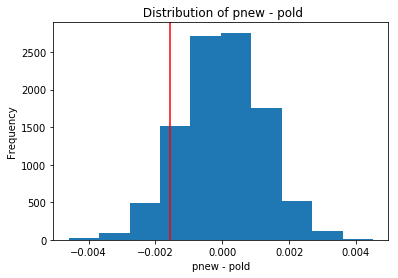

In [30]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);
plt.title(' Distribution of pnew - pold')
plt.xlabel('pnew - pold')
plt.ylabel('Frequency');
plt.axvline(x=obs_diff , color = 'r');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [31]:
obs_diff

-0.0015782389853555567

In [32]:
# estimation of the Null_vals
null_vals= np.random.normal(0 , p_diffs.std(),p_diffs.size)
null_vals

array([  1.49330494e-04,   6.09674333e-04,  -1.03389786e-03, ...,
        -5.46170419e-05,  -2.41230900e-03,   1.71597502e-04])

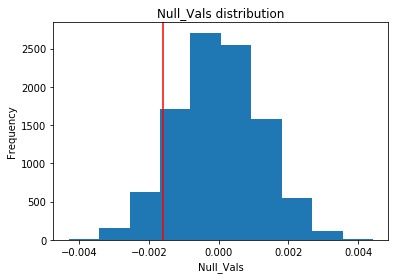

In [33]:
# plotting of null_vals Distribution
plt.hist(null_vals);
plt.title('Null_Vals distribution')
plt.xlabel('Null_Vals')
plt.ylabel('Frequency')
plt.axvline(x= obs_diff , color = 'r');

In [34]:
# calculate the P_value
P_value = (null_vals > obs_diff).mean()
P_value

0.90839999999999999

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

* ***we calculate P_value that used in hypothesis testing to help decide whether to reject the null hypothesis.***
* ***The number of p_value greater than alfa error (Type I error rate (0.05) so we faild to reject the null hypothesis . we should keep the old page.***



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old =df2.query("landing_page == 'old_page'and converted == 1").shape[0]

# number of conversions with the new_page
convert_new =df2.query("landing_page == 'new_page'and converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = df2[df2['landing_page'] == "old_page"].shape[0]

# number of individuals who received new_page
n_new = df2[df2['landing_page'] == "new_page"].shape[0]


In [36]:

count_array = np.array([convert_new , convert_old])
nobs_array = np.array([n_new , n_old])

# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



* ***The Findings agree with the results of the previous test.***


<a id='regression'></a>
### Part III - A regression approach
 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:


In [37]:
# load the main dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
# obstrics dummies of page column variable...
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [39]:
##Use statsmodels and Fitting the Regression model...
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
## summary of the regression model.
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-16 23:30 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [41]:
#reciprocal of coefficient exponentiation 
1/np.exp(results.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


* ***p_value for ab_page is 0.189 that with it we can't reject the null  because it is above our Type I error threshold of 0.05.***
* ***the conclusion is the same like in the previous part, because the p-value also greater than alfa error.***
* ***Hypothesis related to logistic regression  is analysis method to predict a binary outcome but AB testing hypothesis cares about making a choice regarding two probabilities.***
* ***P_value for logistic regression represents a two tailed hypothesis while p_value for AB test represents a one tailed hypothesis and this explain the difference between them.***

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

* ***A bout dataset and factors that may have effect on it , we think the time factor may affect our finding and decisions, but in reality there are many factors have influence on whether or not the user converts, also factors like suffering from change aversion, or convert due to other changes happening on the site.***
* ***Adding more terms will always improve the model regardless of whether the added term adds a significant value***
* ***The disadvantage to adding more terms  lead to over fitting that may lead to modeling failure and its unability to predict.***

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [42]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# Join with the df2 dataframe
df2_new = df2.join(countries, lsuffix='_caller', rsuffix='_countries')
df2_new.head()

,user_id_caller,timestamp,group,landing_page,converted,ab_page,old_page,intercept,user_id_countries,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,834778.0,UK
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,928468.0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,822059.0,UK
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,711597.0,UK
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,710616.0,UK


In [44]:
df2_new.drop('user_id_countries',axis = 1,inplace = True)

In [45]:
# Create the necessary dummy variables
df2_new[['CA', 'UK', 'US']] = pd.get_dummies(df2_new['country'])
df2_new.head()

,user_id_caller,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,UK,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,UK,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,UK,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,UK,0,1,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 



In [46]:
#Create necessary variables.
UK_newpage = df2_new['ab_page'] * df2_new['UK']
df2_new['UK_newpage'] = UK_newpage

In [47]:
#Create necessary variables.
US_newpage = df2_new['ab_page'] * df2_new['US']
df2_new['US_newpage'] = US_newpage

In [48]:
df2_new.head()

,user_id_caller,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,UK,US,UK_newpage,US_newpage
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,UK,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,UK,0,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,UK,0,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,UK,0,1,0,0,0


In [49]:
# Fit your model, and summarize the results
log_2 = sm.Logit(df2_new['converted'] , df2_new[['intercept', 'US', 'US_newpage', 'UK', 'UK_newpage', 'ab_page']])
results2 = log_2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-16 23:30 AIC:              212784.1015
No. Observations:   290584           BIC:              212847.5794
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0497    0.0331  -61.9451  0.0000  -2.1145  -1.9848
US             0.0647    0.0345    1.8777  0.0604  -0.0028   0.1323
US_newpage    -0.0818    0.0482   -1.6981  0.0895  -0.1762   0.0126
UK             0.0651    0.0368    1.7666  0.0773  -0.0071   0.1373
UK_newpage    -0.0699    0.0516   -1.3554  0.1753  -0.1710   0.0312
ab_page        0.0589    0.0462    1.2755  0.2021  -0.0316   0.1494
==================================================================

"""

In [50]:
#coeffecient exponentiation
np.exp(results2.params)

intercept     0.128778
US            1.066881
US_newpage    0.921447
UK            1.067228
UK_newpage    0.932472
ab_page       1.060661
dtype: float64

In [51]:
#reciprocal of coefficient exponentiation 
1/np.exp(results2.params)

intercept     7.765276
US            0.937312
US_newpage    1.085249
UK            0.937007
UK_newpage    1.072419
ab_page       0.942808
dtype: float64

>**Conclusions.**
* ***The results appear the p_values for all factors > 0.05 (alfa error) that indicate we Fail to reject the null hypothesis$$H1  : B1 \neq 0$$.***
* ***coefficient values of ap_page indicates similarity with old page regarding conversion holding all other predictors constant.***
* ***coefficient values of Us and UK indicate similarity with CA regarding conversion holding all other predictors constant.***
* ***coefficient values of interacted ap_page with UK and US indicate similarity with old page regarding conversion holding all other predictors const***
* **As a final conclousion we can say that Country has no great effect on page conversion in addition, and old page shows aslightly higer conversion rate than the new page , so the decision is to keep the old page.**

### Resources

#### web pages used:

* https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/support-or-reject-null-hypothesis/#:~:text=Use%20the%20P%2DValue%20method%20to%20support%20or%20reject%20null%20hypothesis.&text=Step%202%3A%20Compute-,by%20dividing%20the%20number%20of%20positive%20respondents%20from%20the%20number,63%20%2F%20210%20%3D%200.3.
* https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
* www.pandas.pydata.org
* udacity litreatures